# Stohastic gradient and coordinate descent

## Data upload and preparation

Read `Advertising.csv`

In [21]:
import pandas as pd
import numpy as np

In [22]:
ads_df = pd.read_csv('data/Advertising.csv', index_col=0)
ads_df.head()

,TV,radio,newspaper,sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


Check if we have NaN in our data, delete them if they are present:

In [23]:
ads_df.isna().sum()

TV           0
radio        0
newspaper    0
sales        0
dtype: int64

Transform the data into NumPy arrays: X - predictors, y - target

In [24]:
X = np.array(ads_df.drop(['sales'], axis=1))
y = np.array(ads_df['sales'])

## Coordinate descent

In order to have intercept in the equation of regression, append column of 1 to X array:

In [25]:
X = np.hstack([np.ones(X.shape[0]).reshape(-1, 1), X])
y = y.reshape(-1, 1)
print(X.shape, y.shape)

(200, 4) (200, 1)


Data normalization:

In [26]:
X = X / np.sqrt(np.sum(np.square(X), axis=0))

Coordinate descent implementation:

**Given:**

* $X=(x_{ij})$ - observation matrix with dimension $dim(X)=(m, n)$
* $N=1000$ - number of iterations

**Note:** number of iterations indicated for example.

**Algorithm:**
* Create zero parameter vector $w_0=(0, 0,..., 0)^T$
* For all $t=1, 2, ..., N$ iterations:
    * For all $k = 1, 2,..., n$:
        * Fixate values of all features except for $k$ and evaluate prediction of linear regression model. In order to do this, exclude $k$-feature from data and $w_j$ weight from parameters:

        $$h_i = \sum_{j=1}^{k-1} x_{ij}w_{j} + \sum_{j=k+1}^{n} x_{ij}w_j $$

        **Notation:**
        
        *Note that $k$-feature doesn't participate in the sum. Compare this expression with linear regression equation in case of normalized data (when all features participate):*

        $$h_i = \sum_{j=1}^{n} x_{ij}w_{j}$$ 
        
        * Calculate new value of weight $w_k$:

        $$w_k = \sum_{i=1}^{m} x_{ik} (y_i - h_i) = x_k^T(y-h) $$

    * Calculate value of loss function and record loss function modification (all features participate in evaluation of loss function):

        $$\hat{y_i} = \sum_{j=1}^{n}x_{ij}w_j$$
        $$Loss_t = \frac{1}{n} \sum_{i=1}^{m}(y_i-\hat{y_i})^2$$
        
        in vector form:
        
        $$\hat{y} = Xw$$
        $$Loss_t = \frac{1}{n}(y-\hat{y})^T(y-\hat{y})$$

**Algorithm (pseudocode):**
```python

num_iters = #number of iterations
m = # number of strings in X
n = # number of columns in X
w = # vector of n zeros

for i in range(num_iters):
    for k in range(n):
        # Evaluate prediction w/o k factor
        h = (X[:,0:k] @ w[0:k]) + (X[:,k+1:] @ w[k+1:])
        # Refresh w_k
        w[k] =  (X[:,k].T @ (y - h))
        # Evaluate loss function
        cost = sum((X @ w) - y) ** 2)/(len(y))

```

Implement coordinate descent and display weights of linear regression:

In [27]:
num_iters = 1000
w = np.zeros(X.shape[1]).reshape(-1, 1)

for iter in range(num_iters):
    for k in range(X.shape[1]):
        h = (X[:, 0:k] @ w[0:k]) + (X[:, k+1:] @ w[k+1:])
        w[k] = (X[:, k].T @ (y - h))

        cost = sum(((X @ w) - y)**2) / (y.shape[0])

In [28]:
print(f'Weights: {w}')
print(f'MSE: {cost}')

Weights: [[ 41.56217205]
 [110.13144155]
 [ 73.52860638]
 [ -0.55006384]]
MSE: [2.78412631]


Compare results with the results of sklearn version of linear regression:

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
 
model = LinearRegression(fit_intercept=False)
model.fit(X, y)
y_pred = model.predict(X)
 
print(f'Coefficients: {model.coef_}')
print(f'MSE: {mean_squared_error(y, y_pred)}')

Coefficients: [[ 41.56217205 110.13144155  73.52860638  -0.55006384]]
MSE: 2.784126314510936


*The results of both methods are equivalent to each other.*

## Stohastic gradient descent

X standartization:

In [30]:
X = np.array(ads_df.drop(['sales'], axis=1))
y = np.array(ads_df['sales'])

X_st = (X - X.mean(axis=0)) / X.std(axis=0)

Append column of 1:

In [31]:
X_st = np.hstack([np.ones(X_st.shape[0]).reshape(-1, 1), X_st])

`mse_error` function, that calculates MSE:

In [32]:
def mse_error(y_true, y_pred):
    """MSE calculation.

    Args:
        y_true (numpy.ndarray): vector of true target values.
        y_pred (numpy.ndarray): vector of predicted target values.
        
    Returns:
        (float): mean squared error.
    """
    
    return np.sum((y_true - y_pred)**2) / y_true.shape[0]

Make a naïve prediction: predict sales with mean value. Calculate MSE afterwise:

In [33]:
mse_naif = mse_error(y, np.mean(y))
print(f'Naïve prediction: {mse_naif: .3f}')

Naïve prediction:  27.086


Create `lin_pred` function, that makes a prediction out of matrix of predictors *X* and vector of weights *w*:

In [34]:
def lin_pred(X, w):
    """Make a prediction.

    Args:
        X (numpy.ndarray): observation matrix.
        w (numpy.ndarray): vector of weights.
        
    Returns:
        (numpy.ndarray): vector of predicted values.
    """
    
    return X @ w

Create `stoch_grad_step` function to implement step of stohastic gradient descent. The function receives as arguments:
* *X* matrix
* *y* and *w* vectors
* *train_ind* - index of train sample's record (string of matrix *X*) by which vector of weights is modified
* *$\eta$* (eta) - step of gradient descent

The result is modified vector of weights.

Stohastic gradient descent expression:

$$\Large w_j \leftarrow w_j - 2\eta x_{ij}((w_0 + w_1x_{i1} + w_2x_{i2} +  w_3x_{i3}) - y_i)$$

where $i$ is `train_ind` index of train sample, $j$ - index of vector of weights $w$.

In order to write the function:

* calculate direction of step: multiply an object of train sample by 2 and by current relative error.

* return difference between vector of weights and direction of alteration multiplied by gradient step.

In [35]:
def stoch_grad_step(X, y, w, train_ind, eta):
    """Step of stohastic gradient descent, that transforms vector of weights.

    Args:
        X (numpy.ndarray): observation matrix.
        y (numpy.ndarray): target vector.
        w (numpy.ndarray): vector of weights.
        train_ind (int): number of observation.
        eta (float): gradient descent step.
        
    Returns:
        (numpy.ndarray): new vector of weights.
    """
    
    w_new = w - 2 * eta * ((X[train_ind, :] @ w) - y[train_ind]) * X[train_ind, :]
    
    return w_new

Create `stohastic_gradient_descent` function implementing stohastic gradient descent algorithm.

The function receives further arguments:
- *X* feature matrix
- Target vector *y*
- Initial point (model weights)
- Learning rate
- Maximum number of iterations
- Minimum euclidean distance between vectors of weights of adjacent iterations

Each iteration the algorithm records current MSE to a list. The function returns vector of weights and array of MSE.

The algorithm itself consists of further steps:

* Initialize the distance between vectors of weights of adjacent iterations by a large number (e.g. by infinity).
* Create an empty list for MSE recording.
* Create iteration counter.
* Create a cycle while the distance between vectors of weights is larger than that when the run should be ceased (when distances become too small i.e. the algorithm get stuck) and current number of iterations is less than maximum number allowed. Generate random index, record current MSE to the vector of errors, record to a variable current step of stohastic descent. Then calculate current distance between vectors of weights and add 1 to iteration counter.
* Return vector of weights and vector of MSE.

In [36]:
def stohastic_gradient_descent(X, y, w_init, eta=0.01, max_iter=1e+5, eps=1e-5):
    """Stohastic gradient descent implementation.

    Args:
        X (numpy.ndarray): observation matrix.
        y (numpy.ndarray): target vector.
        w_init (numpy.ndarray): initial vector of weights.
        eta (float, optional): learning rate. Defaults to 0.01.
        max_iter (int, optional): maximum number of iterations. Defaults to 1e+5.
        eps (float, optional): minimal norm of gradient step, when the algorithm stops. Defaults to 1e-5.

    Returns:
        (numpy.ndarray, numpy.ndarray): vector of weights, array of MSE.
    """
    
    mse = []    # list of MSE
    iter = 0    # current iteration
    w_dist = np.inf # norm of current gradient step
    w = w_init  # current vector of weights
    
    while (w_dist > eps) & (iter <= max_iter):
        idx = np.random.randint(X.shape[0])
        mse.append(mse_error(y, lin_pred(X, w)))
        w_new = stoch_grad_step(X, y, w, idx, eta)
        w_dist = np.linalg.norm(w_new - w)
        iter += 1
        w = w_new
        
    print(f'Number of iterations: {iter}')
    
    return w, np.array(mse)

Run $10^5$ iterations of stohastic gradient descent. Specify *zero* initial vector of weights. Experiment with the learning rate.

In [37]:
w_sgd, mse_sgd = stohastic_gradient_descent(X_st, y, np.zeros(X_st.shape[1]), eta=1e-4, eps=1e-7)

Number of iterations: 19914


Dependance MSE vs number of iteration:

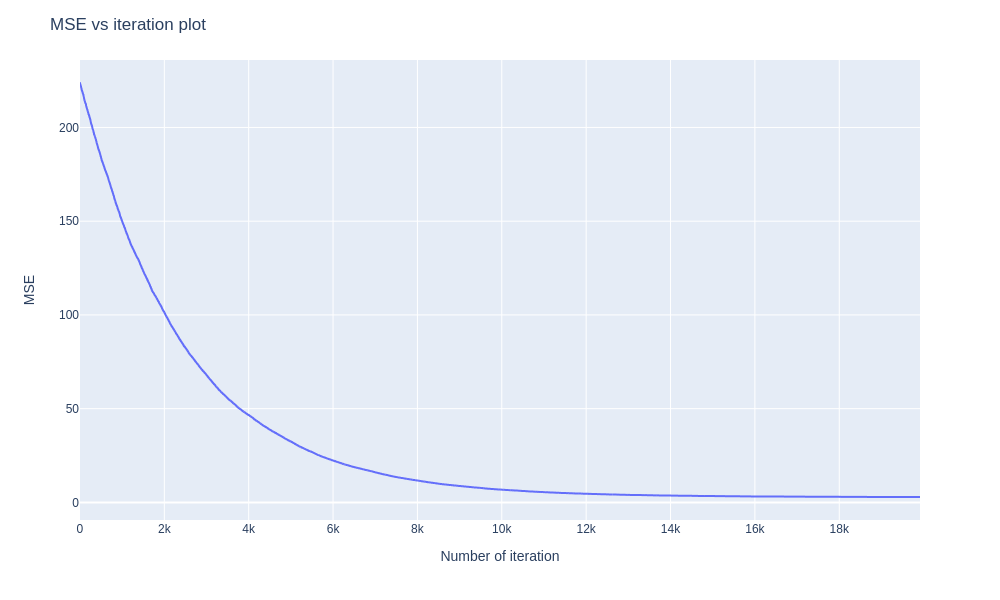

In [38]:
import plotly.express as px

mse_df = pd.DataFrame({'Iteration': range(1, len(mse_sgd) + 1), 
                         'MSE': mse_sgd})

fig_mse = px.line(mse_df, x='Iteration', y='MSE')
fig_mse.update_layout(
        autosize=False,
        width=1000,
        height=600,
        title_text='MSE vs iteration plot'
    )

fig_mse.update_xaxes(title_text='Number of iteration')
fig_mse.update_yaxes(title_text='MSE')
fig_mse.update(layout_showlegend=False)
fig_mse.write_html('images/mse.html')
fig_mse.write_image('images/mse.png')
fig_mse.show('png')

Vector of weights to which algorithm has converged:

In [39]:
print(f'Weights: {w_sgd}')

Weights: [13.74606396  3.88597283  2.68620685  0.07366675]


MSE on last iteration:

In [40]:
print(f'MSE, last iteration: {mse_sgd[-1]: .3f}')

MSE, last iteration:  2.875


*Stohastic gradient descent needs more iterations to converge, but there exists the probability that it converges to global minimum when the loss function isn't convex.*